_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c3_interpolated_1750_100.csv")
training_set = data.iloc[:, 1]
training_set

0       91.100000
1       90.875910
2       90.651821
3       90.427731
4       90.203641
          ...    
1845    70.951821
1846    70.944351
1847    70.936881
1848    70.929412
1849    70.921942
Name: C3, Length: 1850, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(1750)
training_set

0       91.100000
1       90.875910
2       90.651821
3       90.427731
4       90.203641
          ...    
1745     0.220264
1746     0.000000
1747     0.137467
1748     0.000000
1749     0.585592
Name: C3, Length: 1750, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,91.100000,0.000298
1,90.875910,0.000298
2,90.651821,0.000297
3,90.427731,0.000297
4,90.203641,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

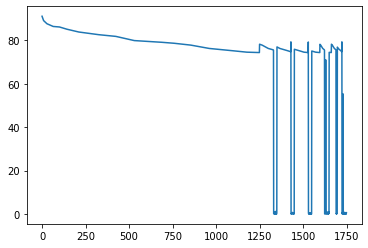

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

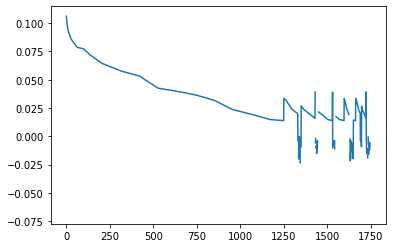

In [11]:
import numpy as np
c0 = 88.0403  # Value for C0
K0 = -0.0012  # Value for K0
K1 = -0.0001  # Value for K1
a = 0.0000    # Value for a
b = 0.0120    # Value for b
c = 2.0334    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    91.100000    90.875910    90.651821    90.427731    90.203641   
351    90.875910    90.651821    90.427731    90.203641    89.979552   
352    90.651821    90.427731    90.203641    89.979552    89.755462   
353    90.427731    90.203641    89.979552    89.755462    89.531373   
354    90.203641    89.979552    89.755462    89.531373    89.307283   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    89.979552    89.755462    89.531373    89.307283    89.094118  ...   
351    89.755462    89.531373    89.307283    89.094118    89.015686  ...   
352    89.531373    89.307283    89.094118    89.015686    88.937255  ...   
353    89.307283    89.094118    89.015686    88.937255    88.858824  ...   
354    89.094118    89.015686    88.937255    88.858824    88.780392  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   81.423343    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1300, 1, 251) (1300, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(88.0403, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0012, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0001, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0120, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.0334, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
17/17 [==============================] - 2s 35ms/step - loss: 6103.6807 - val_loss: 4370.9150
Epoch 2/500
17/17 [==============================] - 0s 6ms/step - loss: 6021.6943 - val_loss: 4324.2817
Epoch 3/500
17/17 [==============================] - 0s 8ms/step - loss: 5952.5601 - val_loss: 4279.3501
Epoch 4/500
17/17 [==============================] - 0s 13ms/step - loss: 5883.9185 - val_loss: 4234.9790
Epoch 5/500
17/17 [==============================] - 0s 6ms/step - loss: 5816.0249 - val_loss: 4191.1436
Epoch 6/500
17/17 [==============================] - 0s 6ms/step - loss: 5748.8398 - val_loss: 4147.8027
Epoch 7/500
17/17 [==============================] - 0s 5ms/step - loss: 5682.3198 - val_loss: 4104.9292
Epoch 8/500
17/17 [==============================] - 0s 4ms/step - loss: 5616.4302 - val_loss: 4062.5059
Epoch 9/500
17/17 [==============================] - 0s 4ms/step - loss: 5551.1548 - val_loss: 4020.5198
Epoch 10/500
17/17 [==============================] -

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 442ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[7.60084967e+01, 7.59412698e+01, 7.58740430e+01, 7.58068161e+01,
        7.57395892e+01, 7.56723623e+01, 7.56051354e+01, 0.00000000e+00,
        9.74150002e-01, 3.55119079e-01, 7.64558315e-01, 1.19662857e+00,
        0.00000000e+00, 7.69569561e+01, 7.68225023e+01, 7.66880486e+01,
        7.65535948e+01, 7.64191410e+01, 7.62923436e+01, 7.62251167e+01,
        7.61578898e+01, 7.60906629e+01, 7.60234360e+01, 7.59562092e+01,
        7.58889823e+01, 7.58217554e+01, 7.57545285e+01, 7.56873016e+01,
        7.56200747e+01, 7.55528478e+01, 7.54831046e+01, 7.54041130e+01,
        7.53251214e+01, 7.52461298e+01, 7.51671382e+01, 7.50881466e+01,
        7.50091550e+01, 7.49301634e+01, 7.48511718e+01, 7.47721802e+01,
        0.00000000e+00, 0.00000000e+00, 4.43340153e-01, 2.13404834e-01,
        1.30534396e-01, 4.37472165e-01, 0.00000000e+00, 7.58366947e+01,
        7.57694678e+01, 7.57022409e+01, 7.56350140e+01, 7.55677871e+01,
        7.55005602e+01, 7.54216667e+01, 7.53426751e+01, 7.526368

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([71.48839869, 71.48373016, 71.47906162, 71.47439309, 71.46972456,
       71.46505602, 71.46038749, 71.45571895, 71.45105042, 71.44638189,
       71.44171335, 71.43704482, 71.43237628, 71.42770775, 71.42303922,
       71.41837068, 71.41370215, 71.40903361, 71.40436508, 71.39969655,
       71.39502801, 71.39035948, 71.38569094, 71.38102241, 71.37635387,
       71.37168534, 71.36701681, 71.36234827, 71.35767974, 71.3530112 ,
       71.34834267, 71.34367414, 71.3390056 , 71.33433707, 71.32966853,
       71.325     , 71.32033147, 71.31566293, 71.3109944 , 71.30632586,
       71.30165733, 71.2969888 , 71.29232026, 71.28765173, 71.28298319,
       71.27831466, 71.27364613, 71.26897759, 71.26430906, 71.25964052,
       71.25497199, 71.25030345, 71.24563492, 71.24096639, 71.23629785,
       71.23162932, 71.22696078, 71.22229225, 71.21762372, 71.21295518,
       71.20828665, 71.20361811, 71.19831933, 71.19084967, 71.18338002,
       71.17591036, 71.16844071, 71.16097106, 71.1535014 , 71.14

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

43.844759493925004
29.652178572512852
